# REFMAP laboratory listening test 1 analysis: Exploratory data analysis — all data

## Setup

In [4]:
# -*- coding: utf-8 -*-
import sys
import os
# Build a path from the notebook's parent directory to the python modules
module_path = os.path.abspath(os.path.join('..'))

# Add to sys.path if not already present
if module_path not in sys.path:
    sys.path.append(module_path)

# import statements
import numpy as np
import pandas as pd
from PyQt5.QtWidgets import QFileDialog, QApplication
import librosa
from refmap_psychoacoustics.dsp import filterFuncs
from refmap_psychoacoustics.utils.formatFuncs import displayRndVal, roundTrad
from scipy import stats
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pingouin as pg


In [5]:
# set plot parameters
sns.set_style('white')
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams.update({'font.size': 16})
mpl.rcParams['figure.autolayout'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE,
       labelsize=MEDIUM_SIZE)    # fontsize of the axes title and x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

mycolours = [(0, 102, 255), (0, 204, 153), (255, 0, 102), (74, 111, 152),
             (251, 164, 49), (204, 153, 255), (90, 192, 255), (80, 245, 233),
             (255, 90, 192), (164, 201, 242), (255, 254, 139), (255, 243, 255)]
mycolours = [tuple(shade/255 for shade in colour) for colour in mycolours]


# enable copy-on-write mode for Pandas (will be default from Pandas 3.0)
pd.options.mode.copy_on_write = True

# check/open QApplication instance
if not QApplication.instance():
    app = QApplication(sys.argv)
else:
    app = QApplication.instance() 

Set the saveplots toggle to True if plot saving is desired:

In [6]:
saveplots = True

if saveplots:
    # select figure output save path
    outFigPath = QFileDialog.getExistingDirectory(caption=r"Select output folder to save plots")

    # create subfolders if not already existing
    try:
        os.mkdir(os.path.join(outFigPath, "svg"))
    except FileExistsError:
        pass

    try:
        os.mkdir(os.path.join(outFigPath, "pdf"))
    except FileExistsError:
        pass

## Import data and organise

In [7]:
# import data
fileExts = "*.csv"

# Parts A and B
dataByStimFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdata_ByStim.csv",
                                                       caption=r"Open refmap_listest1_testdata_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTest = pd.read_csv(dataByStimFilePath, index_col=0)

partsABDataFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdata_BySubj.csv",
                                                     caption=r"Open refmap_listest1_testdata_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
partsABdataBySubj = pd.read_csv(partsABDataFilePath, index_col=False)


# Part A
dataByStimAFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataA_ByStim.csv",
                                                       caption=r"Open refmap_listest1_testdataA_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTestA = pd.read_csv(dataByStimAFilePath, index_col=0)

partADataFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataA_BySubj.csv",
                                                     caption=r"Open refmap_listest1_testdataA_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
partADataBySubj = pd.read_csv(partADataFilePath, index_col=False)


# Part B
dataByStimBFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataB_ByStim.csv",
                                                       caption=r"Open refmap_listest1_testdataB_ByStim.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
dataByStimTestB = pd.read_csv(dataByStimBFilePath, index_col=0)

partBDataFilePath = list(QFileDialog.getOpenFileName(filter="refmap_listest1_testdataB_BySubj.csv",
                                                     caption=r"Open refmap_listest1_testdataB_BySubj.csv in: \03 Experiment\Experiment 1\Analysis\PostProcess"))[0]
partBDataBySubj = pd.read_csv(partBDataFilePath, index_col=False)


C:\Users\m_lot\AppData\Local\Temp\ipykernel_42352\505543600.py:21: DtypeWarning: Columns (379) have mixed types. Specify dtype option on import or set low_memory=False.
  partADataBySubj = pd.read_csv(partADataFilePath, index_col=False)


In [8]:
# categorise columns

for dataset in [dataByStimTest, partsABdataBySubj, dataByStimTestA, partADataBySubj]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"], ordered=True)
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "-16", "-10", "-4", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "42", "48", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Overflight", "Landing", "Takeoff"], ordered=True)
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "M300", "T150"], ordered=True)

for dataset in [dataByStimTestB, partBDataBySubj]:
    dataset['AmbientEnv'] = pd.Categorical(dataset['AmbientEnv'], ["Park", "Street"], ordered=True)
    dataset['SNRlevel'] = pd.Categorical(dataset['SNRlevel'], ["No UAS", "2", "8"], ordered=True)
    dataset['UASLAeq'] = pd.Categorical(dataset['UASLAeq'], ["No UAS", "54", "60"], ordered=True)
    dataset['UASOperation'] = pd.Categorical(dataset['UASOperation'], ["No UAS", "Overflight"], ordered=True)
    dataset['UASType'] = pd.Categorical(dataset['UASType'], ["No UAS", "H520", "T150"], ordered=True)


## Exploratory data analysis and checking

In this section, exploratory plots are used to examine the data for information and possible trends.

### Examination of mean vs median responses

The relationship between the median and mean annoyance responses are examined, to explore how the use of one or other as a measure for central tendency within the data might affect modelling outcomes and inferences.

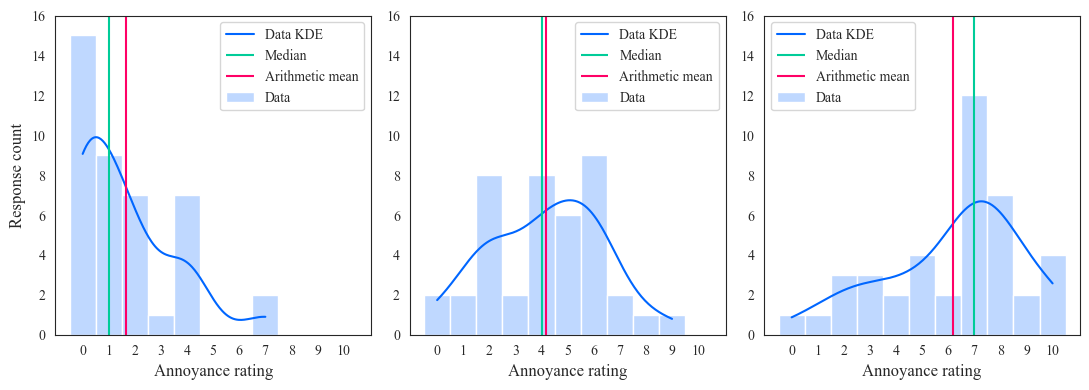

In [13]:
# histogram plot of extreme annoyance distributions for Part A

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))

data = [partADataBySubj.loc[partADataBySubj['StimFile']
                            == "A2.wav", 'Annoyance'],
        partADataBySubj.loc[partADataBySubj['StimFile']
                            == "A2_H520_F_2_R.wav", 'Annoyance'],
        partADataBySubj.loc[partADataBySubj['StimFile']
                            == "A2_H520_L_1.wav", 'Annoyance']]

leglocs = ["upper right", "best", "upper left"]

for ii, ax in enumerate(axs):
    sns.histplot(data=data[ii], color=mycolours[0], alpha=0.25,
                 bins=np.arange(-0.5, 11.5, 1), ax=ax, kde=True)
    ax.vlines(x=np.median(data[ii]), ymin=0, ymax=20,
              colors=mycolours[1], linewidth=1.5)
    ax.vlines(x=np.mean(data[ii]), ymin=0, ymax=20,
              colors=mycolours[2], linewidth=1.5)
    ax.set(xticks=range(0, 11, 1), ylim=[0, 16], xlabel="Annoyance rating")
    ax.legend(labels=["Data KDE", "Median", "Arithmetic mean", "Data"], loc=leglocs[ii])
    if ii == 0:
        ax.set(ylabel="Response count")
    else:
        ax.set(ylabel=None)

if saveplots:

    filename = "MedianVsMeanAnnoyHistH520"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')
plt.show()


The histogram plot gives one example from Part A of how assymetrical response distributions could result in the tendency for the mean values to 'lean inwards' from the extreme ends of the bounded response scales. 

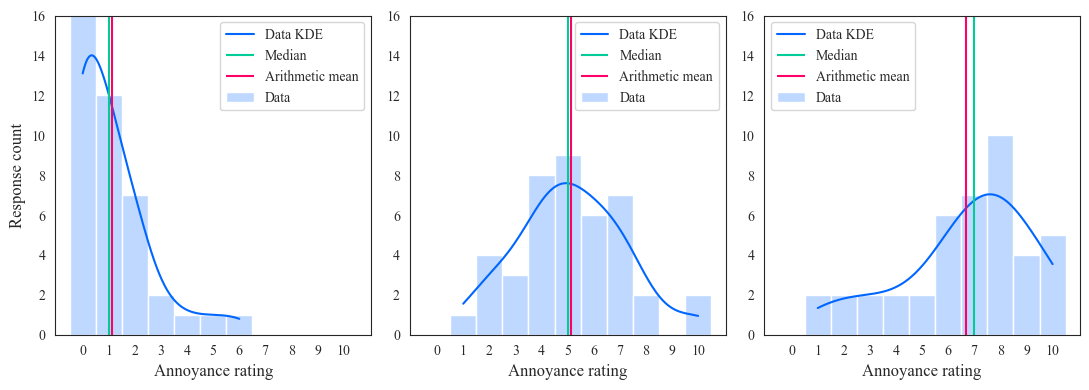

In [ ]:
# histogram plot of extreme annoyance distributions for Part B

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 4))

data = [partBDataBySubj.loc[partBDataBySubj['StimFile']
                            == "B2.wav", 'Annoyance'],
        partBDataBySubj.loc[partBDataBySubj['StimFile']
                            == "B2_T150_F_2_L_3.wav", 'Annoyance'],
        partBDataBySubj.loc[partBDataBySubj['StimFile']
                            == "B2_T150_F_1_R_9.wav", 'Annoyance']]

leglocs = ["upper right", "best", "upper left"]

for ii, ax in enumerate(axs):
    sns.histplot(data=data[ii], color=mycolours[0], alpha=0.25,
                 bins=np.arange(-0.5, 11.5, 1), ax=ax, kde=True)
    ax.vlines(x=np.median(data[ii]), ymin=0, ymax=20,
              colors=mycolours[1], linewidth=1.5)
    ax.vlines(x=np.mean(data[ii]), ymin=0, ymax=20,
              colors=mycolours[2], linewidth=1.5)
    ax.set(xticks=range(0, 11, 1), ylim=[0, 16], xlabel="Annoyance rating")
    ax.legend(labels=["Data KDE", "Median", "Arithmetic mean", "Data"], loc=leglocs[ii])
    if ii == 0:
        ax.set(ylabel="Response count")
    else:
        ax.set(ylabel=None)


if saveplots:
    
    filename = "MedianVsMeanAnnoyHistT150"
    
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()


This histogram plot shows a less extreme example from Part B of how assymetrical response distributions could result in the tendency for the mean values to 'lean inwards' from the extreme ends of the bounded response scales. In this case, the mean and the median are in closer agreement, although the example towards the upper extreme still shows the mean being pulled downwards by atypical responses at the low end.

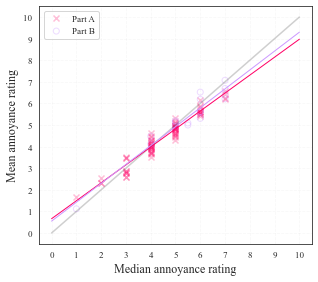

In [ ]:
# median vs mean annoyance for both Parts A and B
fig, ax = plt.subplots(figsize=(4.5, 4))

ax.plot([0, 10], [0, 10], linestyle='-', color=[0.25, 0.25, 0.25], alpha=0.25)
ax.scatter(x=dataByStimTestA['AnnoyMedian'], y=dataByStimTestA['AnnoyMean'],
           color=mycolours[2], alpha=0.25, label="Part A", marker='x')
ax.set(xticks=range(0, 11), xlabel="Median annoyance rating",
       yticks=range(0, 11), ylabel="Mean annoyance rating")

# linear regression line
b, a = np.polyfit(dataByStimTestA['AnnoyMedian'], dataByStimTestA['AnnoyMean'],
                  deg=1)
xseq = np.linspace(0, 10, num=11)
ax.plot(xseq, a + b * xseq, color=mycolours[2], linewidth=1)

ax.scatter(x=dataByStimTestB['AnnoyMedian'], y=dataByStimTestB['AnnoyMean'],
           color=mycolours[5], alpha=0.35, label="Part B", marker='o',
           facecolor='none')
ax.set(xticks=range(0, 11), xlabel="Median annoyance rating",
       yticks=range(0, 11), ylabel="Mean annoyance rating")

# linear regression line
b, a = np.polyfit(dataByStimTestB['AnnoyMedian'], dataByStimTestB['AnnoyMean'],
                  deg=1)
xseq = np.linspace(0, 10, num=11)
ax.plot(xseq, a + b * xseq, color=mycolours[5], linewidth=1)


ax.grid(alpha=0.15, linestyle='--')
ax.legend()

if saveplots:
    filename = "MedianVsMeanAnnoyScatReg"
    
    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()


This scatter plot and linear regression demonstrates how the use of mean annoyance ratings results in a compressed response range compared with the use of the median values, and that the effect is marginally greater with Part A than with Part B.

### Comparison of response judgement types

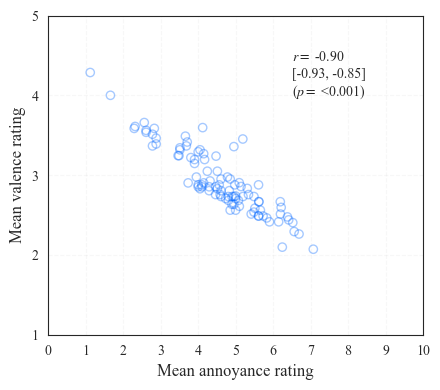

In [22]:
fig, ax = plt.subplots(figsize=(4.5, 4))

ax.scatter(x=dataByStimTest['AnnoyMean'], y=dataByStimTest['ValenceMean'],
           color=mycolours[0], alpha=0.35, marker='o', facecolor='none')
ax.set(xticks=range(0, 11), xlabel="Mean annoyance rating",
       yticks=range(1, 6), ylabel="Mean valence rating")

testCorr = pg.corr(dataByStimTest['AnnoyMean'],
                   dataByStimTest['ValenceMean'],
                   method='pearson')

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.text(6.5, 4, r"$r=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2, floor=False) + ", "
        + displayRndVal(rCI[1], 2, floor=False) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")

ax.grid(alpha=0.15, linestyle='--')

if saveplots:
    filename = "MeanAnnoyVsMeanValenceScatCorr"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')
plt.show()

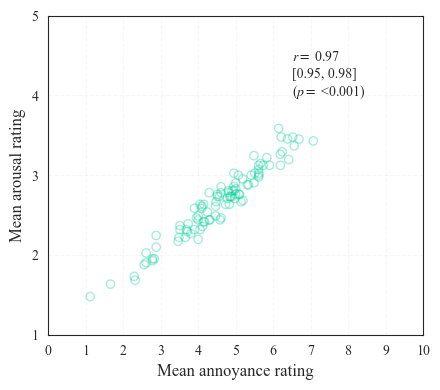

In [20]:
fig, ax = plt.subplots(figsize=(4.5, 4))

ax.scatter(x=dataByStimTest['AnnoyMean'], y=dataByStimTest['ArousalMean'],
           color=mycolours[1], alpha=0.35, marker='o', facecolor='none')
ax.set(xticks=range(0, 11), xlabel="Mean annoyance rating",
       yticks=range(1, 6), ylabel="Mean arousal rating")

testCorr = pg.corr(dataByStimTest['AnnoyMean'],
                   dataByStimTest['ArousalMean'],
                   method='pearson')

rVal = displayRndVal(testCorr['r'].iloc[0], 2)
pVal = displayRndVal(testCorr['p-val'].iloc[0], 3)
rCI = testCorr['CI95%'].iloc[0]

ax.text(6.5, 4, r"$r=$ " + rVal
        + "\n" + "[" + displayRndVal(rCI[0], 2, floor=False) + ", "
        + displayRndVal(rCI[1], 2, floor=False) + "]"
        + "\n" + "(" + r"$p=$ " + pVal + ")")

ax.grid(alpha=0.15, linestyle='--')

if saveplots:
    filename = "MeanAnnoyVsMeanArousalScatCorr"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')
plt.show()

## Highly annoyed judgements

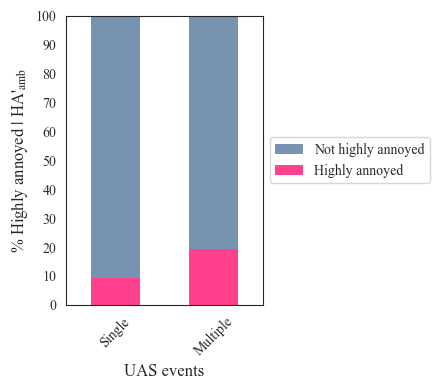

In [93]:
# stacked proportional bar plot for % highly annoyed by UAS by session
# plot stacked proportional bar plot for the proportion of high annoyance in each group using matplotlib
fig, ax = plt.subplots(figsize=(4.5, 4))

x_var, y_var = "SessionPart", "dHighAnnoy"
df_grouped = partsABdataBySubj.groupby(x_var, observed=True)[y_var].value_counts(normalize=True).unstack(y_var)
# relabel columns
df_grouped.columns = ["Not highly annoyed", "Highly annoyed"]
df_grouped = df_grouped.reset_index()
# relabel rows with arbitrary values
df_grouped[x_var] = pd.Categorical(["Single", "Multiple"], ordered=True)

# plot
df_grouped.plot(kind='bar', stacked=True, x=x_var, y=["Highly annoyed", "Not highly annoyed"], ax=ax,
                color=mycolours[2:4], alpha=0.75, edgecolor='none')

ax.set(ylabel=r"% Highly annoyed $|$ HA'$_\mathrm{amb}$",
         xlabel="UAS events", ylim=[0, 1], yticks=np.arange(0, 1.1, 0.1), yticklabels=np.arange(0, 101, 10))

# set x-axis labels to rotated angle for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# place legend outside axis at centre right bbox
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)

plt.show()



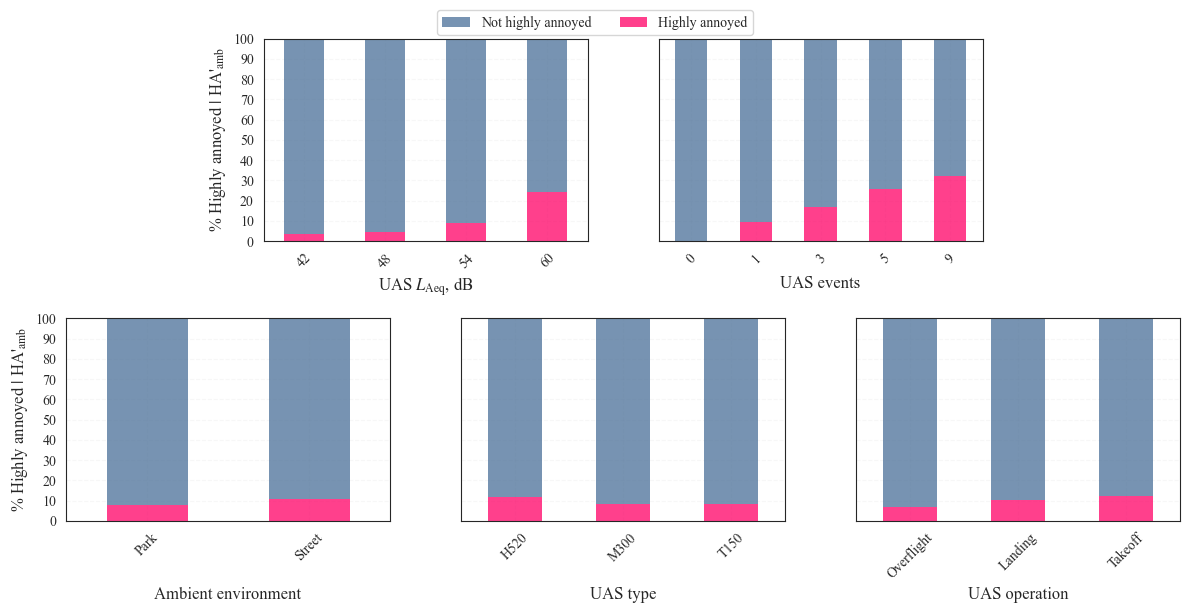

In [11]:
# stacked proportional bar plot for % highly annoyed by UAS by UAS events
# plot stacked proportional bar plot for the proportion of high annoyance in each group using matplotlib
fig = plt.figure(figsize=(12, 6))
nPlots = 5
gs = mpl.gridspec.GridSpec(2, 6, figure=fig)
axs = list()

for ii in range(0, nPlots):
    if ii < 2:
        axs.append(plt.subplot(gs[0, 1 + 2*ii:3 + 2*ii]))
    else:
        axs.append(plt.subplot(gs[1, 1 + 2*ii - nPlots:3 + 2*ii - nPlots]))

## First row
### LAeq
x_var, y_var = "UASLAeq", "dHighAnnoy"
df_grouped = partsABdataBySubj.groupby(x_var, observed=True)[y_var].value_counts(normalize=True).unstack(y_var)
df_grouped.drop(index="No UAS", inplace=True)
# relabel columns
df_grouped.columns = ["Not highly annoyed", "Highly annoyed"]
df_grouped = df_grouped.reset_index()

# plot
df_grouped.plot(kind='bar', stacked=True, x=x_var, y=["Highly annoyed", "Not highly annoyed"], ax=axs[0],
                color=mycolours[2:4], alpha=0.75, edgecolor='none')

axs[0].set(ylabel=r"% Highly annoyed $|$ HA'$_\mathrm{amb}$",
        xlabel=r"UAS $L_\mathrm{Aeq}$, dB", ylim=[0, 1], yticks=np.arange(0, 1.1, 0.1),
        yticklabels=np.arange(0, 101, 10))
axs[0].grid(alpha=0.15, linestyle='--')
# set x-axis labels to rotated angle for better readability
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=45)

# omit legend
axs[0].legend().set_visible(False)


### Events
x_var, y_var = "UASEvents", "dHighAnnoy"
df_grouped = partsABdataBySubj.groupby(x_var, observed=True)[y_var].value_counts(normalize=True).unstack(y_var)
# relabel columns
df_grouped.columns = ["Not highly annoyed", "Highly annoyed"]
df_grouped = df_grouped.reset_index()

# plot
df_grouped.plot(kind='bar', stacked=True, x=x_var, y=["Highly annoyed", "Not highly annoyed"], ax=axs[1],
                color=mycolours[2:4], alpha=0.75, edgecolor='none')

axs[1].set(ylabel=None,
            xlabel="UAS events", ylim=[0, 1], yticks=np.arange(0, 1.1, 0.1),
            yticklabels=[])
axs[1].grid(alpha=0.15, linestyle='--')

# set x-axis labels to rotated angle for better readability and set labels to integer strings
axs[1].set_xticklabels(df_grouped['UASEvents'].astype(int))
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=45)

# omit legend
axs[1].legend().set_visible(False)

## Second row
### Ambient env
x_var, y_var = "AmbientEnv", "dHighAnnoy"
df_grouped = partADataBySubj.groupby(x_var, observed=True)[y_var].value_counts(normalize=True).unstack(y_var)

# relabel columns
df_grouped.columns = ["Not highly annoyed", "Highly annoyed"]
df_grouped = df_grouped.reset_index()
# relabel rows with arbitrary values

# plot
df_grouped.plot(kind='bar', stacked=True, x=x_var, y=["Highly annoyed", "Not highly annoyed"], ax=axs[2],
                color=mycolours[2:4], alpha=0.75, edgecolor='none')

axs[2].set(ylabel=r"% Highly annoyed $|$ HA'$_\mathrm{amb}$",
        xlabel=r"Ambient environment", ylim=[0, 1], yticks=np.arange(0, 1.1, 0.1),
        yticklabels=np.arange(0, 101, 10))
axs[2].grid(alpha=0.15, linestyle='--')
# set x-axis labels to rotated angle for better readability
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=45)

# omit legend
axs[2].legend().set_visible(False)

### UAS type
x_var, y_var = "UASType", "dHighAnnoy"
df_grouped = partADataBySubj.groupby(x_var, observed=True)[y_var].value_counts(normalize=True).unstack(y_var)
df_grouped.drop(index="No UAS", inplace=True)

# relabel columns
df_grouped.columns = ["Not highly annoyed", "Highly annoyed"]
df_grouped = df_grouped.reset_index()
# relabel rows with arbitrary values

# plot
df_grouped.plot(kind='bar', stacked=True, x=x_var, y=["Highly annoyed", "Not highly annoyed"], ax=axs[3],
                color=mycolours[2:4], alpha=0.75, edgecolor='none')

axs[3].set(ylabel=None,
        xlabel=r"UAS type", ylim=[0, 1], yticks=np.arange(0, 1.1, 0.1),
        yticklabels=[])
axs[3].grid(alpha=0.15, linestyle='--')
# set x-axis labels to rotated angle for better readability
axs[3].set_xticklabels(axs[3].get_xticklabels(), rotation=45)

# omit legend
axs[3].legend().set_visible(False)

### UAS operation
x_var, y_var = "UASOperation", "dHighAnnoy"
df_grouped = partADataBySubj.groupby(x_var, observed=True)[y_var].value_counts(normalize=True).unstack(y_var)
df_grouped.drop(index="No UAS", inplace=True)

# relabel columns
df_grouped.columns = ["Not highly annoyed", "Highly annoyed"]
df_grouped = df_grouped.reset_index()
# relabel rows with arbitrary values

# plot
df_grouped.plot(kind='bar', stacked=True, x=x_var, y=["Highly annoyed", "Not highly annoyed"], ax=axs[4],
                color=mycolours[2:4], alpha=0.75, edgecolor='none')

axs[4].set(ylabel=None,
        xlabel=r"UAS operation", ylim=[0, 1], yticks=np.arange(0, 1.1, 0.1),
        yticklabels=[])
axs[4].grid(alpha=0.15, linestyle='--')
# set x-axis labels to rotated angle for better readability
axs[4].set_xticklabels(axs[4].get_xticklabels(), rotation=45)

# omit legend
axs[4].legend().set_visible(False)

# place legend outside axis at centre right bbox
lines_labels = [axs[4].get_legend_handles_labels()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(handles=lines, labels=labels, loc='upper center', bbox_to_anchor=(0.5, 1.025), reverse=True, ncols=2)

# align x-axis labels
fig.align_xlabels()

# save plot
if saveplots:
    
    filename = "PtsABHighAnnoyStackedBarMulti"

    plt.savefig(os.path.join(outFigPath, "svg", filename + ".svg"),
                format='svg')
    
    plt.savefig(os.path.join(outFigPath, "pdf", filename + ".pdf"),
                format='pdf')

plt.show()



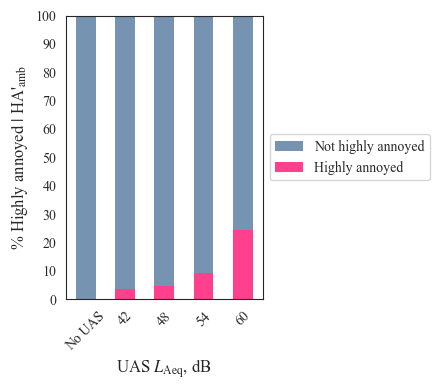

In [ ]:
# stacked proportional bar plot for % highly annoyed by UAS by UAS LAeq
# plot stacked proportional bar plot for the proportion of high annoyance in each group using matplotlib
fig, ax = plt.subplots(figsize=(4.5, 4))

x_var, y_var = "UASLAeq", "dHighAnnoy"
df_grouped = partsABdataBySubj.groupby(x_var, observed=True)[y_var].value_counts(normalize=True).unstack(y_var)
# relabel columns
df_grouped.columns = ["Not highly annoyed", "Highly annoyed"]
df_grouped = df_grouped.reset_index()
# relabel rows with arbitrary values

# plot
df_grouped.plot(kind='bar', stacked=True, x=x_var, y=["Highly annoyed", "Not highly annoyed"], ax=ax,
                color=mycolours[2:4], alpha=0.75, edgecolor='none')

ax.set(ylabel=r"% Highly annoyed $|$ HA'$_\mathrm{amb}$",
        xlabel=r"UAS $L_\mathrm{Aeq}$, dB", ylim=[0, 1], yticks=np.arange(0, 1.1, 0.1), yticklabels=np.arange(0, 101, 10))
# set x-axis labels to rotated angle for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# place legend outside axis at centre right bbox
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)

plt.show()



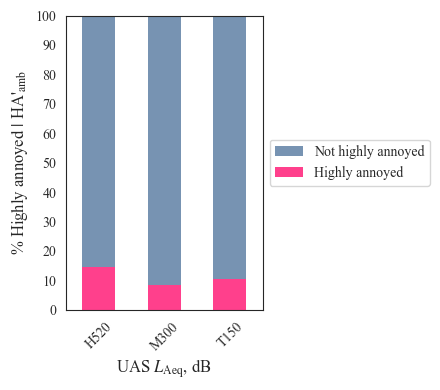

In [ ]:
# stacked proportional bar plot for % highly annoyed by UAS by UAS type
# plot stacked proportional bar plot for the proportion of high annoyance in each group using matplotlib
fig, ax = plt.subplots(figsize=(4.5, 4))

x_var, y_var = "UASType", "dHighAnnoy"
df_grouped = partsABdataBySubj.groupby(x_var, observed=True)[y_var].value_counts(normalize=True).unstack(y_var)
df_grouped.drop(index="No UAS", inplace=True)

# relabel columns
df_grouped.columns = ["Not highly annoyed", "Highly annoyed"]
df_grouped = df_grouped.reset_index()
# relabel rows with arbitrary values

# plot
df_grouped.plot(kind='bar', stacked=True, x=x_var, y=["Highly annoyed", "Not highly annoyed"], ax=ax,
                color=mycolours[2:4], alpha=0.75, edgecolor='none')

ax.set(ylabel=r"% Highly annoyed $|$ HA'$_\mathrm{amb}$",
        xlabel=r"UAS $L_\mathrm{Aeq}$, dB", ylim=[0, 1], yticks=np.arange(0, 1.1, 0.1), yticklabels=np.arange(0, 101, 10))
# set x-axis labels to rotated angle for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# place legend outside axis at centre right bbox
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), reverse=True)

plt.show()

